In [2]:
%matplotlib inline

In [3]:
from fastai.vision.all import *

# Data

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
Path.BASE_PATH = path

In [6]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [7]:
items = get_image_files(path)
items[0]

Path('training/4/47823.png')

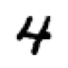

In [8]:
im = PILImageBW.create(items[0])
im.show();

In [9]:
(path/'training').ls()

(#10) [Path('training/4'),Path('training/7'),Path('training/9'),Path('training/5'),Path('training/8'),Path('training/0'),Path('training/2'),Path('training/1'),Path('training/6'),Path('training/3')]

In [10]:
splits = GrandparentSplitter('training', 'testing')(items)

In [11]:
len(splits)

2

In [106]:
type(splits[0])

list

In [12]:
dsets = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=splits)

In [13]:
dsets

(#70000) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...]

In [14]:
dsets.train

(#60000) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...]

In [15]:
dsets.valid

(#10000) [(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4)),(PILImageBW mode=L size=28x28, TensorCategory(4))...]

In [125]:
dsets.train[15000]

(PILImageBW mode=L size=28x28, TensorCategory(9))

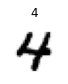

In [17]:
show_at(dsets.train, 0);

In [18]:
tfms = [ToTensor(), CropPad(size=34), RandomCrop(size=28)]
bs = 128

In [19]:
dls = dsets.dataloaders(bs=bs, after_item=tfms, after_batch=[IntToFloatTensor, Normalize()])

In [143]:
dsrc1 = Datasets([items[0]]*128, tfms=[[PILImageBW.create], [parent_label, Categorize]], splits=(list(range(128)), list()))

In [144]:
items[0]

Path('training/4/47823.png')

In [148]:
dbunch1 = dsrc1.dataloaders(bs=bs, after_item=tfms, after_batch=[IntToFloatTensor])

In [149]:
dsrc1.train

(#128) [(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0))...]

In [150]:
dsrc1.valid

(#0) []

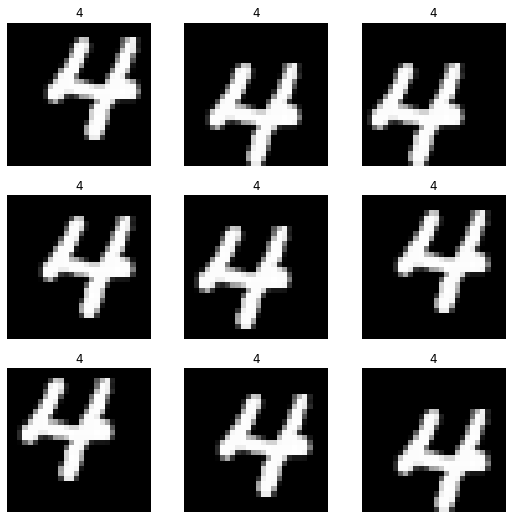

In [154]:
dbunch1.show_batch(cmap='gray')

In [155]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

# Basic CNN with batchnorm

In [157]:
def conv(ni, nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [158]:
model = nn.Sequential(
    conv(1,8), #14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8,16), #7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,32), #4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32,16), #2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16,10), #1
    nn.BatchNorm2d(10),
    Flatten() # remove (1,1) grid
)

In [159]:
learn = Learner(dls, model, nn.CrossEntropyLoss(), metrics=accuracy)

In [160]:
learn.summary()

Sequential (Input shape: 128)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
__________________________________________________

In [165]:
xb = xb.cuda()

In [166]:
model(xb).shape

torch.Size([128, 10])

SuggestedLRs(lr_min=1.258925437927246, lr_steep=0.19952623546123505)

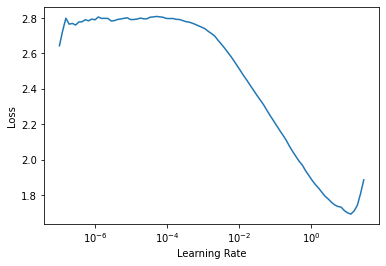

In [167]:
learn.lr_find(end_lr=100)

In [168]:
learn.fit_one_cycle(3, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.224082,0.139585,0.954200,00:33
1,0.136804,0.077456,0.974500,00:31
2,0.075089,0.038233,0.986800,00:28


# Refactor

In [169]:
def conv2(ni,nf): return ConvLayer(ni,nf, stride=2)

In [170]:
model2 = nn.Sequential(
    conv2(1,8), # 14
    conv2(8,16), # 7
    conv2(16,32), # 4
    conv2(32,16), # 2
    conv2(16,10), # 1
    Flatten() # remove (1,1) grid
)

In [171]:
learn2 = Learner(dls, model2, nn.CrossEntropyLoss(), metrics=accuracy)

In [172]:
learn2.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.222557,0.277686,0.908100,00:27
1,0.184409,0.161210,0.947200,00:30
2,0.145463,0.170031,0.949600,00:32
3,0.127353,0.098663,0.966100,00:36
4,0.114603,0.137986,0.953800,00:39
5,0.084335,0.070685,0.978100,00:40
6,0.072937,0.047322,0.984600,00:40
7,0.058748,0.034668,0.987800,00:50
8,0.045925,0.027179,0.991200,00:37
9,0.044646,0.024544,0.991600,00:37


In [173]:
torch.cuda.is_available()

True

# Resnet-ish

In [174]:
class ResBlock(Module):
    def __init__(self, nf):
        self.conv1 = ConvLayer(nf,nf)
        self.conv2 = ConvLayer(nf,nf)
        
    def forward(self,x):
        return x + self.conv2(self.conv1(x))

In [175]:
model = nn.Sequential(
    conv2(1,8),
    ResBlock(8),
    conv2(8,16),
    ResBlock(16),
    conv2(16,32),
    ResBlock(32),
    conv2(32,16),
    ResBlock(16),
    conv2(16,10),
    Flatten()
)

In [176]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni,nf), ResBlock(nf))

In [177]:
model = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

In [178]:
learn = Learner(dls, model, nn.CrossEntropyLoss(), metrics=accuracy)

SuggestedLRs(lr_min=0.19498445987701415, lr_steep=0.6918309926986694)

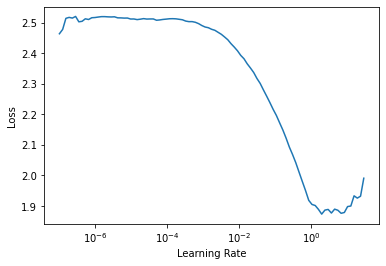

In [179]:
learn.lr_find(end_lr=100)

In [180]:
learn.fit_one_cycle(10, 5e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.185116,0.180556,0.945300,00:44
1,0.117744,0.292641,0.916800,00:45
2,0.088050,0.061341,0.979400,00:45
3,0.068563,0.049685,0.985200,01:01
4,0.056551,0.047454,0.983900,00:42
5,0.056035,0.035999,0.988400,00:48
6,0.039706,0.020636,0.993100,00:36
7,0.029815,0.019864,0.994000,00:38
8,0.025357,0.016416,0.994600,00:41
9,0.023578,0.015152,0.994600,00:41


In [205]:
torch.cuda.list_gpu_processes()

"cuda driver can't be loaded, is cuda enabled?"

In [212]:
torch.cuda.set_device('gpu-0')

RuntimeError: Invalid device string: 'gpu-0'

In [214]:
xb.device

device(type='cuda', index=0)

In [215]:
SequentialEx??

Init signature: SequentialEx(*layers)
Source:        
class SequentialEx(Module):
    "Like `nn.Sequential`, but with ModuleList semantics, and can access module input"
    def __init__(self, *layers): self.layers = nn.ModuleList(layers)

    def forward(self, x):
        res = x
        for l in self.layers:
            res.orig = x
            nres = l(res)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            res.orig, nres.orig = None, None
            res = nres
        return res

    def __getitem__(self,i): return self.layers[i]
    def append(self,l):      return self.layers.append(l)
    def extend(self,l):      return self.layers.extend(l)
    def insert(self,i,l):    return self.layers.insert(i,l)
File:           ~/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/layers.py
Type:           PrePostInitMeta
Subclasses:     DynamicUnet


In [216]:
MergeLayer??

Init signature: MergeLayer(dense: bool = False)
Source:        
class MergeLayer(Module):
    "Merge a shortcut with the result of the module by adding them or concatenating them if `dense=True`."
    def __init__(self, dense:bool=False): self.dense=dense
    def forward(self, x): return torch.cat([x,x.orig], dim=1) if self.dense else (x+x.orig)
File:           ~/anaconda3/envs/fastbook/lib/python3.8/site-packages/fastai/layers.py
Type:           PrePostInitMeta
Subclasses:     


In [217]:
densenet121??

Signature: densenet121(pretrained=False, progress=True, **kwargs)
Source:   
def densenet121(pretrained=False, progress=True, **kwargs):
    r"""Densenet-121 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet121', 32, (6, 12, 24, 16), 64, pretrained, progress,
                     **kwargs)
File:      ~/anaconda3/envs/fastbook/lib/python3.8/site-packages/torchvision/models/densenet.py
Type:      function
